In [0]:
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [0]:
# IMPORTANT: always restart runtime after executing this cell for the first time
!pip install matplotlib==3.1.0
!pip install pillow==4.0.0

In [0]:
#!pip install matplotlib==3.1.0
#!pip install pillow==4.0.0

In [0]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [0]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Tensorflow version 1.15.0
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir /content/Dataset

In [0]:
!cp -r /content/drive/My\ Drive/Dataset/zip /content/Dataset/zip

In [0]:
!cp -r /content/WeatherBlindTestSet/ /content/Dataset/useful

In [0]:
#!cp -r /content/drive/My\ Drive/Dataset/WeatherBlindTestSet.zip /content/Dataset

"Extra", this code was only executed once

In [0]:
#cp -r /content/drive/My\ Drive/models /content/Dataset

In [0]:
#!cp -r /content/drive/My\ Drive/Dataset/WeatherBlindTestSet.zip /content/Dataset/blind/

In [0]:
#!cp -r /content/blind_preditcions.csv /content/drive/My\ Drive/

In [0]:
#model = keras.models.load_model('/content/Dataset/models/transferModel.h5')














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




End of extra

In [0]:
!cp -r /content/Dataset/models/ /content/drive/My\ Drive/

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-999ad005e86c>", line 1, in <module>
    get_ipython().system('cp -r /content/Dataset/models/ /content/drive/My\\ Drive/')
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_shell.py", line 96, in system
    output = _system_commands._system_compat(self, *args, **kwargs)  # pylint:disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_system_commands.py", line 438, in _system_compat
    shell.var_expand(cmd, depth=2), clear_streamed_output=False)
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_system_commands.py", line 195, in _run_command
    return _monitor_process(parent_pty, epoll, p, cmd, update_stdin_widget)
  File "/usr/lib/python3.6/contextlib.py", line 88, in __exit__
    next(self.gen)
  File "/usr/local/lib

KeyboardInterrupt: ignored

In [0]:
drive.flush_and_unmount() #this flushes, so that the things you put in the drive folder actually appear in drive

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import zipfile
import pandas as pd
from PIL import Image
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datadir = '/content/Dataset/' # change according to google drive base dir location
input_datadir = os.path.join(datadir, 'zip') # change according to google drive compressed archives path location

# preprocess images

## extract images metadata

In [0]:
data = []
for filename in os.listdir(input_datadir):
    if filename.endswith('zip'):
        compressed_archive = os.path.join(input_datadir, filename)
        with zipfile.ZipFile(compressed_archive, 'r') as zip_ref:
            for f in zip_ref.namelist():
                if f[-1] != '/':
                    with zip_ref.open(f) as zip_image:
                        img_path = os.path.split(f)
                        img_class = os.path.split(img_path[0])[1]
                        img = Image.open(zip_image) # read only image metadata
                        data.append({'compressed_archive': compressed_archive, \
                                    'image_directory': img_path[0], \
                                    'image_name': img_path[1], \
                                    'image_width': img.width, \
                                    'image_height': img.height, \
                                    'image_mode': img.mode, \
                                    'target': img_class})
    
df = pd.DataFrame(data=data, columns=['compressed_archive', 'image_directory', 'image_name', 'image_width', 'image_height', 'image_mode', 'target']).sort_values('compressed_archive')
df.to_csv(os.path.join(datadir, 'images_metadata.csv'), index=False)

In [0]:
resize_shape = (int(df['image_width'].mean()), int(df['image_height'].mean()))
ratio = resize_shape[0] / resize_shape[1]
#resize_shape = (int(400), int(400))
#x = (ratio * 160000) ** 0.5
resize_shape = (int(400 * ratio), int(400)) # (469, 400)
print(resize_shape)

(469, 400)


In [0]:
datadir = '/content/Dataset/' # change according to google drive base dir location
input_datadir = os.path.join(datadir, 'blind') # change according to google drive compressed archives path location

In [0]:
data = []
for filename in os.listdir(input_datadir):
    if filename.endswith('zip'):
        compressed_archive = os.path.join(input_datadir, filename)
        with zipfile.ZipFile(compressed_archive, 'r') as zip_ref:
            for f in zip_ref.namelist():
                if f[-1] != '/':
                    with zip_ref.open(f) as zip_image:
                        img_path = os.path.split(f)
                        img_class = os.path.split(img_path[0])[1]
                        img = Image.open(zip_image) # read only image metadata
                        data.append({'compressed_archive': compressed_archive, \
                                    'image_directory': img_path[0], \
                                    'image_name': img_path[1], \
                                    'image_width': img.width, \
                                    'image_height': img.height, \
                                    'image_mode': img.mode, \
                                    'target': img_class})
    
df = pd.DataFrame(data=data, columns=['compressed_archive', 'image_directory', 'image_name', 'image_width', 'image_height', 'image_mode', 'target']).sort_values('compressed_archive')
df.to_csv(os.path.join(datadir, 'images_metadata.csv'), index=False)

## split images into train and test set

In [0]:
X, y = df.loc[:, df.columns != 'target'], df.loc[:, ['target']]
X, y = shuffle(X, y, random_state=25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3200, 6) (800, 6) (3200, 1) (800, 1)


In [0]:
train = pd.DataFrame(data=X_train)
train['target'] = y_train
#train.sort_values('compressed_archive', inplace=True)
test = pd.DataFrame(data=X_test)
test['target'] = y_test
#test.sort_values('compressed_archive', inplace=True)

In [0]:
def transform_image(img, output_shape):
    return img.resize(output_shape)

# create train and test folders
train_datadir = os.path.join(datadir, 'train')
test_datadir = os.path.join(datadir, 'test')
classes = df['target'].unique()

if not os.path.exists(train_datadir) and not os.path.exists(test_datadir):
    for c in classes:
        os.makedirs(os.path.join(train_datadir, c), exist_ok=True)
        os.makedirs(os.path.join(test_datadir, c), exist_ok=True)

    for csv_prefix, dataset, dataset_dir in zip(['train', 'test'], [train, test], [train_datadir, test_datadir]):
        for group_name, df_group in dataset.groupby(dataset['compressed_archive']):
            with zipfile.ZipFile(group_name, 'r') as zip_ref:
                for row_index, row in df_group.iterrows():
                    with zip_ref.open(os.path.join(row['image_directory'], row['image_name'])) as zip_image:
                        img = Image.open(zip_image)
                        resized_img = transform_image(img, resize_shape)
                        resized_img.save(os.path.join(dataset_dir, row['target'], row['image_name']))
        dataset.to_csv(os.path.join(datadir, '{}_images_metadata.csv'.format(csv_prefix)), index=False)

In [0]:
batch_size = 64 # or 32, 64
input_shape = (299, 299)
train_datagen = ImageDataGenerator( # featurewise_center=True, featurewise_std_normalization=True,
    rescale = 1. / 255, \
    zoom_range=0.3, \
    rotation_range=0, \
    width_shift_range=0.2, \
    height_shift_range=0.2, \
    #brightness_range=(0.5, 1.5), \
    horizontal_flip=True, \
    vertical_flip=False, \
    fill_mode='reflect') # 'nearest', 'reflect', 'wrap'

train_generator = train_datagen.flow_from_directory(
    directory=train_datadir,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_datadir,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Image input (299, 299, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 3200 training samples from 4 classes.
Loaded 800 test samples from 4 classes.


SUNNY


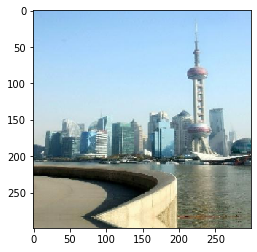

HAZE


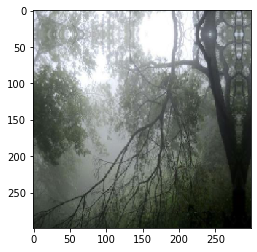

SUNNY


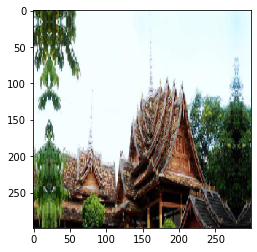

In [0]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

CNN from scratch

In [0]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def myVGG19(input_shape, num_classes):
  img_input = Input(shape=input_shape)
  # Block 1
  x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
  x = Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # Block 2
  x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
  x = Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # Block 3
  x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
  x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
  x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
  x = Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv4')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # Block 4
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv4')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

  # Block 5
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
  x = Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv4')(x)
  x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

  # Classification block
  x = Flatten(name='flatten')(x)
  x = Dense(4096, activation='relu', name='fc1')(x)
  x = Dense(4096, activation='relu', name='fc2')(x)
  x = Dense(num_classes, activation='softmax', name='predictions')(x)
  model = Model(img_input, x, name='vgg19')
  adam = optimizers.Adam(lr=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model
 
# create the model
model = myVGG19(input_shape,num_classes)
model.summary()








Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       

Train

In [0]:
from keras import callbacks

stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=4)

steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

try:
    history = model.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=test_generator,\
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





50/50 [==============================] - 99s 2s/step - loss: 1.2801 - acc: 0.3687 - val_loss: 1.1868 - val_acc: 0.4025
Epoch 2/100
50/50 [==============================] - 85s 2s/step - loss: 1.0584 - acc: 0.5250 - val_loss: 0.8835 - val_acc: 0.6613
Epoch 3/100
50/50 [==============================] - 86s 2s/step - loss: 0.8879 - acc: 0.6206 - val_loss: 0.8143 - val_acc: 0.6750
Epoch 4/100
50/50 [==============================] - 86s 2s/step - loss: 0.8143 - acc: 0.6453 - val_loss: 0.7430 - val_acc: 0.7100
Epoch 5/100
50/50 [==============================] - 87s 2s/step - loss: 0.7272 - acc: 0.6941 - val_loss: 0.7031 - val_acc: 0.7288
Epoch 6/100
50/50 [==============================] - 86s 2s/step - loss: 0.7195 - acc: 0.6925 - val_loss: 0.7401 - val_acc: 0.7037
Epoch 7/100
50/50 [==============================] - 86s 2s/step - loss: 0.7029 - acc: 0.7134 - val_loss: 0.6591

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


save model

In [0]:
import os

models_dir = datadir + '/models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(model,'ScratchModel')


Model saved successfully on file /content/Dataset//models/ARGOS-sc5-2013_20classes_alexnet_100_epochs.h5



In [0]:
testset = datadir + '/test/'
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)


Found 800 images belonging to 4 classes.
13/13 [==============================] - 4s 331ms/step
Test loss: 0.550253
Test accuracy: 0.792500


In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


Found 800 images belonging to 4 classes.
13/13 [==============================] - 4s 331ms/step
              precision    recall  f1-score   support

        HAZE      0.791     0.885     0.835       218
       RAINY      0.806     0.607     0.693       191
       SNOWY      0.713     0.746     0.729       193
       SUNNY      0.862     0.914     0.887       198

    accuracy                          0.792       800
   macro avg      0.793     0.788     0.786       800
weighted avg      0.793     0.792     0.789       800



In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))
  

Found 800 images belonging to 4 classes.
13/13 [==============================] - 4s 337ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
RAINY            ->  SNOWY             	38 	4.75 % 
RAINY            ->  HAZE              	26 	3.25 % 
SNOWY            ->  RAINY             	21 	2.62 % 
SNOWY            ->  HAZE              	20 	2.50 % 
RAINY            ->  SUNNY             	11 	1.38 % 
HAZE             ->  SNOWY             	10 	1.25 % 
HAZE             ->  SUNNY             	10 	1.25 % 
SUNNY            ->  SNOWY             	10 	1.25 % 
SNOWY            ->  SUNNY             	8 	1.00 % 
HAZE             ->  RAINY             	5 	0.62 % 
SUNNY            ->  HAZE              	5 	0.62 % 
SUNNY            ->  RAINY             	2 	0.25 % 


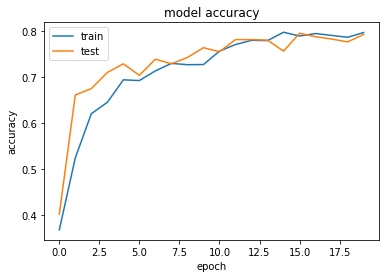

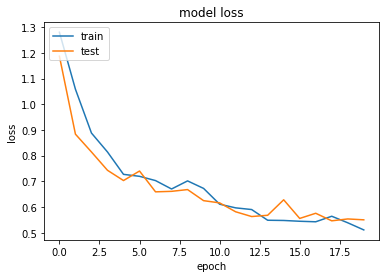

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transfer learning

In [0]:
from keras import applications
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers


def load_backbone_net(input_shape, metrics=['accuracy']):
    # define input tensor
    input0 = Input(shape=input_shape)

    # load a pretrained model on imagenet without the final dense layer
    #feature_extractor = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input0)
    #feature_extractor = applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=input0)
    #feature_extractor = applications.nasnet.NASNetLarge(include_top=False, weights='imagenet', input_tensor=input0)
    feature_extractor = applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input0)
    feature_extractor = feature_extractor.output
    feature_extractor = Model(input=input0, output=feature_extractor, name='feature_extractor')
    optimizer = 'SGD' #'adam' #alternative 'SGD'

    feature_extractor.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=metrics)

    return feature_extractor

def transferNet(feature_extractor, num_classes, output_layer_name, trainable_layers):
    
    # get the original input layer tensor
    input_t = feature_extractor.get_layer(index=0).input

    # set the feture extractor layers as non-trainable
    for idx,layer in enumerate(feature_extractor.layers):
      if layer.name in trainable_layers:
        layer.trainable = True
      else:
        layer.trainable = False

    # get the output tensor from a layer of the feature extractor
    output_extractor = feature_extractor.get_layer(name = output_layer_name).output
    
    #output_extractor = MaxPooling2D(pool_size=(4,4))(output_extractor)

    # flat the output of a Conv layer
    flatten = Flatten()(output_extractor) 
    flatten_norm = BatchNormalization()(flatten)

    # add a Dense layer
    dense = Dropout(0.4)(flatten_norm)
    dense = Dense(200, activation='relu')(dense)
    dense = BatchNormalization()(dense)
    
    # add a Dense layer
    dense = Dropout(0.4)(dense)
    dense = Dense(100, activation='relu')(dense)
    dense = BatchNormalization()(dense)

    # add the final output layer
    dense = BatchNormalization()(dense)
    dense = Dense(num_classes, activation='softmax')(dense)
    
    model = Model(input=input_t, output=dense, name="transferNet")
    
    optimizer = 'SGD' #'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

    return model

# load the pre-trained model
feature_extractor = load_backbone_net(input_shape)
feature_extractor.summary()

# choose the layer from which you can get the features (block5_pool the end, glob_pooling to get the pooled version of the output)
name_output_extractor = 'conv_7b_ac' # "block5_pool"
trainable_layers = [] # ["block5_conv3"]

# build the transfer model
transfer_model = transferNet(feature_extractor, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()




219062272/219055592 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="feature_extractor", inputs=Tensor("in..., outputs=Tensor("co...)`


Model: "feature_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="transferNet", inputs=Tensor("in..., outputs=Tensor("de...)`


Model: "transferNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________

In [0]:
# fit the transferNet on the training data
from keras import callbacks

os.makedirs(os.path.join(datadir, 'models'), exist_ok=True)
checkpoint = callbacks.ModelCheckpoint(os.path.join(datadir, 'models', 'inception_resnet_v2.h5'), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
stopping = callbacks.EarlyStopping(monitor='val_acc', patience=3)

steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps = test_generator.n // test_generator.batch_size + 1

try:
    history_transfer = transfer_model.fit_generator(train_generator, epochs=100, verbose=1, callbacks=[stopping], \
                    steps_per_epoch=steps_per_epoch, \
                    validation_data=test_generator, \
                    validation_steps=val_steps)
except KeyboardInterrupt:
    pass

Epoch 1/100
50/50 [==============================] - 76s 2s/step - loss: 0.4177 - acc: 0.8413 - val_loss: 0.6072 - val_acc: 0.7775
Epoch 2/100
50/50 [==============================] - 69s 1s/step - loss: 0.4150 - acc: 0.8356 - val_loss: 0.5821 - val_acc: 0.7900
Epoch 3/100
50/50 [==============================] - 69s 1s/step - loss: 0.4128 - acc: 0.8403 - val_loss: 0.5706 - val_acc: 0.7887
Epoch 4/100
50/50 [==============================] - 69s 1s/step - loss: 0.4064 - acc: 0.8456 - val_loss: 0.5693 - val_acc: 0.7975
Epoch 5/100
50/50 [==============================] - 70s 1s/step - loss: 0.3885 - acc: 0.8563 - val_loss: 0.5724 - val_acc: 0.7987
Epoch 6/100
50/50 [==============================] - 69s 1s/step - loss: 0.3945 - acc: 0.8569 - val_loss: 0.5482 - val_acc: 0.8013
Epoch 7/100
50/50 [==============================] - 69s 1s/step - loss: 0.3998 - acc: 0.8459 - val_loss: 0.5500 - val_acc: 0.7963
Epoch 8/100
50/50 [==============================] - 69s 1s/step - loss: 0.3965 - a

In [0]:
model_filename = os.path.join(datadir, 'models', 'altSaveTransfer.h5')
transfer_model.save(filename)

In [0]:
import os

models_dir = datadir + 'models/'

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model
savemodel(transfer_model,'transferModel')


Model saved successfully on file /content/Dataset/models/transferModel.h5



In [0]:
testset = datadir + '/test/'
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = transfer_model.evaluate_generator(test_generator,verbose=1,steps=val_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)

Found 800 images belonging to 4 classes.
13/13 [==============================] - 5s 389ms/step
Test loss: 0.535635
Test accuracy: 0.807500


In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))


Found 800 images belonging to 4 classes.
13/13 [==============================] - 10s 796ms/step
              precision    recall  f1-score   support

        HAZE      0.754     0.817     0.784       218
       RAINY      0.898     0.785     0.838       191
       SNOWY      0.771     0.803     0.787       193
       SUNNY      0.832     0.823     0.827       198

    accuracy                          0.807       800
   macro avg      0.814     0.807     0.809       800
weighted avg      0.812     0.807     0.808       800



In [0]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

val_steps=test_generator.n//test_generator.batch_size+1

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

preds = transfer_model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(classnames[k[0]],classnames[k[1]],k[2],k[2]*100.0/test_generator.n))

Found 800 images belonging to 4 classes.
13/13 [==============================] - 5s 387ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SNOWY            ->  HAZE              	24 	3.00 % 
RAINY            ->  SNOWY             	20 	2.50 % 
SUNNY            ->  HAZE              	20 	2.50 % 
HAZE             ->  SUNNY             	18 	2.25 % 
HAZE             ->  SNOWY             	17 	2.12 % 
RAINY            ->  HAZE              	14 	1.75 % 
SUNNY            ->  SNOWY             	9 	1.12 % 
SNOWY            ->  SUNNY             	8 	1.00 % 
RAINY            ->  SUNNY             	7 	0.88 % 
SNOWY            ->  RAINY             	6 	0.75 % 
SUNNY            ->  RAINY             	6 	0.75 % 
HAZE             ->  RAINY             	5 	0.62 % 


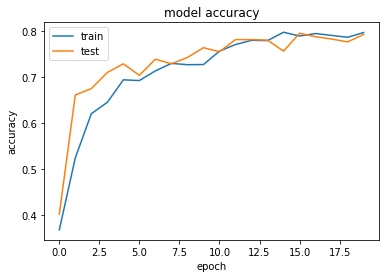

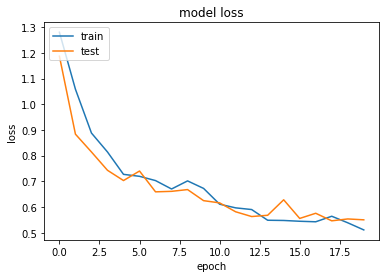

In [0]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Predict

This will not work if the blind test set is not in the right position already

In [0]:
!unzip /con

Archive:  /content/Dataset/blind/WeatherBlindTestSet.zip
   creating: WeatherBlindTestSet/
  inflating: WeatherBlindTestSet/0068.jpg  
  inflating: WeatherBlindTestSet/1441.jpg  
  inflating: WeatherBlindTestSet/0242.jpg  
  inflating: WeatherBlindTestSet/0322.jpg  
  inflating: WeatherBlindTestSet/1319.jpg  
  inflating: WeatherBlindTestSet/0794.jpg  
  inflating: WeatherBlindTestSet/1494.jpg  
  inflating: WeatherBlindTestSet/0047.jpg  
  inflating: WeatherBlindTestSet/0906.jpg  
  inflating: WeatherBlindTestSet/0983.jpg  
  inflating: WeatherBlindTestSet/1048.jpg  
  inflating: WeatherBlindTestSet/1265.jpg  
  inflating: WeatherBlindTestSet/0433.jpg  
  inflating: WeatherBlindTestSet/0425.jpg  
  inflating: WeatherBlindTestSet/0933.jpg  
  inflating: WeatherBlindTestSet/1371.jpg  
  inflating: WeatherBlindTestSet/0927.jpg  
  inflating: WeatherBlindTestSet/0198.jpg  
  inflating: WeatherBlindTestSet/1390.jpg  
  inflating: WeatherBlindTestSet/0437.jpg  
  inflating: WeatherBlindTest

In [0]:
input_shape = (299, 299)
 
test_datagen = ImageDataGenerator(
    rescale = 1. / 255)
 
test_generator = test_datagen.flow_from_directory(
    directory="/content/Dataset/useful/",
    target_size=input_shape,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
 
model = keras.models.load_model('/content/Dataset/models/transferModel.h5')
print(model.summary())
 
val_steps=test_generator.n // test_generator.batch_size + 1
 
# predictions from loaded model
preds = model.predict_generator(test_generator, verbose=1, steps=val_steps)
 
Ypred = pd.Series(np.argmax(preds, axis=1)).apply(lambda x: classnames[x]) # classnames: labels taken from trained data
Ypred.to_csv('blind_predictions.csv', header=False, index=False)

Found 1500 images belonging to 2 classes.
Model: "transferNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
______________________________________________

In [0]:
print(model.summary())

val_steps=test_generator.n // test_generator.batch_size + 1

# predictions from loaded model
preds = model.predict_generator(test_generator, verbose=1, steps=val_steps)

Ypred = pd.Series(np.argmax(preds, axis=1)).apply(lambda x: classnames[x]) # classnames: labels taken from trained data
Ypred.to_csv('blind_predictions.csv', header=False, index=False)

Model: "transferNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________